# Fischer Linear Discriminant Analysis

Kernel Fisher Discriminant Analysis (Kernel FDA) é um método de redução de dimensionalidade e classificação, capaz de projetar datasets com grande número de dimensões em sub-espaços reduzidos, assim como o PCA e a LDA. Esse sub-espaço é otimizado para maximizar a dispersão entre classes e minimizar a dispersão intra-classes, assim como a LDA. A vantagem dessa versão é que ela implementa o kernel-trick, assim como o SVM e o Kernel PCA, possibilitando uma representação dos dados antes não-linearmente separáveis em um sub-espaço reduzido em que as classes sejam linearmente separáveis.

O Kernel FDA classifica os vetores comparando suas projeções no sub-espaço com os centróides das classes. Com isso em mente, adicionar uma nova classe pode significar simplesmente adicionar um novo centróide. Nesse sentido, no exemplo de hoje vamos abordar o Kernel FDA não apenas para redução de dimensionalidade, mas também para classificação e `one shot learning`.

## Instalando o pacote

Podemos utilizar uma implementação do kfda disponível [aqui](https://pypi.org/project/kfda/).

In [1]:
#!pip install kfda

## Carregando o dataset

Vamos usar o  dataset MNIST para um primeiro exemplo. Utilizaremos apenas 6000 amostras para economizar tempo e memória.

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=True)
#X = (X - 127.5) / 127.5
X = np.array(X)/255.
y = np.array(y)

# 60000 x 784 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=6000, stratify=y)

Como uma boa pratica, podemos vizualizar os dados:

In [4]:
import matplotlib.pyplot as plt
import random
import itertools

In [5]:
test_indices = random.sample(range(X_test.shape[0]), 16)
test_sample = X_test[test_indices]
test_sample_labels = y_test[test_indices]

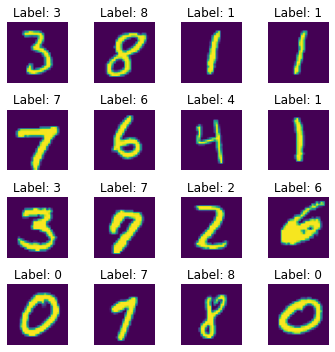

In [6]:
f, axs = plt.subplots(4, 4, figsize=(5, 5))
flattened_axs = itertools.chain(*axs)

for ax, img, label in zip(flattened_axs, test_sample, test_sample_labels):
    ax.axis('off')
    ax.imshow(img.reshape(28,28))
    ax.set_title(f'Label: {label}')

plt.tight_layout()
plt.show()

## Treinamento

O `Kfda` foi implementado de modo a ter uma interface similar ao `scikit-learn`.

Sendo assim, podemos usar apenas `.fit` para iniciar o treinamento.

In [1]:
from kfda import Kfda
cls = Kfda(kernel='rbf', n_components=9)
cls.fit(X_train, y_train)

## Avaliando o modelo

Podemos usar `.score()` para avaliar o modelo. Nesse exemplo, o resultado fica frequentemente por volta de 0.95-96, indicando uma alta taxa de acerto.

In [8]:
print('Resultados:')
test_score = cls.score(X_test, y_test)
print(f'Sobre o conjunto de teste: {test_score}')
train_score = cls.score(X_train, y_train)
print(f'Sobre o conjunto de treinamento: {train_score}')

Resultados:
Sobre o conjunto de testes: 0.95903125
Sobre o conjunto de treinamento: 1.0


Visualizando as predições para ter uma idéia de onde o classificador acertou ou errou. 

Nesse caso, o modelo conseguiu uma acurácia de aproximadamente 96%.

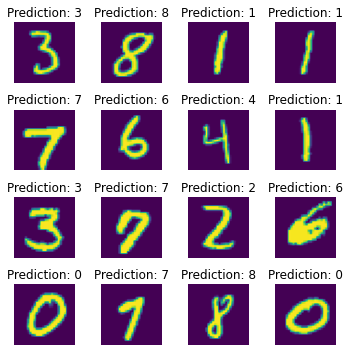

In [9]:
predictions = cls.predict(test_sample)

f, axs = plt.subplots(4, 4, figsize=(5, 5))

flattened_axs = itertools.chain(*axs)

for ax, img, prediction in zip(flattened_axs, test_sample, predictions):
    (ax.axis('off'))
    ax.imshow(img.reshape(28,28))
    ax.set_title(f'Prediction: {prediction}')
plt.tight_layout()

# Oneshot Learning

Esse exemplo será treinado considerando apenas amostras de digitos de 0 a 8. A idéia é apresentar uma amostra de classe 9 e que, sem nenhum 'retreino', o modelo seja capaz de identificar que a amostra pertence a uma nova classe. Vamos primeiro separar os 9's do conjunto de treinamento.

In [10]:
nines_mask = y_train == '9'
X_train_nines = X_train[nines_mask]
X_train = X_train[~nines_mask]
y_train_nines = y_train[nines_mask]
y_train = y_train[~nines_mask]

Agora vamos treinar o modelo considerando apenas as amostras de classe entre 0 e 8. Note que `n_componentes` e 8 em vez de 9. Isso porque o número máximo de direções no sub-espaço de Fischer é $c-1$, e agora so temos 9 classes.

In [11]:
cls = Kfda(kernel='rbf', n_components=8)
print('Fitting...')
cls.fit(X_train, y_train)

Fitting...


/home/roder/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Kfda(kernel='rbf', n_components=8)

Podemos utilizar `.fit_additional` para introduzir uma nova classe. Qualquer quantidade de novas classes podem ser fornecidas. Nenhum 'retreino' é executado, o que pode ser observado na execução muito rápida.

In [12]:
cls.fit_additional(X_train_nines[:1], y_train_nines[:1])

/home/roder/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Kfda(kernel='rbf', n_components=8)

Qualquer quantidade de novas amostras de treinamento para múltiplas classes podem ser introduzidas utilizando `.fit_additional`. O resultado final fica em torno de 0.93, o que implica que o classificador foi capaz de reconhecer os 9s com sucesso.

In [13]:
print('Resultados:')
test_score = cls.score(X_test, y_test)
print(f'Sobre o conjunto de teste: {test_score}')
train_score = cls.score(X_train, y_train)
print(f'Sobre o conjunto de treinamento: {train_score}')

Resultados:
Sobre o conjunto de teste: 0.935875
Sobre o conjunto de treinamento: 1.0


# Visualizando as representações

Podemos rodar o código abaixo para gerar as representações, que podem alimentar o [Projetor](https://projector.tensorflow.org/) do Tensorflow para produzir uma visualização UMAP.

In [14]:
#from sklearn.datasets import fetch_openml
#from sklearn.model_selection import train_test_split

from kfda import Kfda

X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=True)
X = np.array(X)/255.
y = np.array(y)

# Em caso de pouca memória, reduza o tamanho do conjunto de treinamento
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=6000, stratify=y)

# Removendo os 9s do conjunto de treinamento
nines_mask = y_train == '9'
X_train_nines = X_train[nines_mask]
X_train = X_train[~nines_mask]
y_train_nines = y_train[nines_mask]
y_train = y_train[~nines_mask]

# Train
cls = Kfda(kernel='rbf', n_components=8)
print('Ajustando...')
train_embeddings = cls.fit_transform(X_train, y_train)

# Mostra um unico 9 para o algoritmo.
# Os mesmos pesos sao usados e nao há re-treinamento.
print('Adicionando a classe 9')
cls.fit_additional(X_train_nines[:1], y_train_nines[:1])
print('Resultados:')

# Mostra os resultados
test_score = cls.score(X_test, y_test)
print(f'Sobre o conjunto de teste: {test_score}')
train_score = cls.score(X_train, y_train)
print(f'Sobre o conjunto de treinamento: {train_score}')

print('Gerando as representacoes...')
test_embeddings = cls.transform(X_test)

np.savetxt('mnist_oneshot_test_embeddings.tsv',
           test_embeddings, delimiter='\t')
np.savetxt('mnist_oneshot_test_labels.tsv', y_test, delimiter='\t', fmt="%s")
np.savetxt('mnist_oneshot_train_labels.tsv', y_train, delimiter='\t', fmt="%s")
print('Representacoes salvas em *.tsv! Conecte-as https://projector.tensorflow.org/ para visualização.')

Ajustando...


/home/roder/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Adicionando a classe 9
Resultados:


/home/roder/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Sobre o conjunto de testes: 0.92821875
Sobre o conjunto de treinamento: 1.0
Gerando as representacoes...
Representacoes salvas em *.tsv! Conecte-as https://projector.tensorflow.org/ para visualizacao.


In [18]:
#########

Cada cor representa um dígito diferente, e as representações mostram claramente que as classes são separáveis.

Podemos também observar o quão efetiva são essas representações em apenas 2 dimensões. 
Ao usarmos apenas 2 componentes em vez de 9, teremos uma classificação menos acurada, porém, é uma abordagem muito útil para mostrar visualmente a efetividade de 2 componentes nessa tarefa. 

Vamos primeiro treinar um novo classificador:

In [15]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=True)

X = np.array(X)/255.
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=6000, stratify=y)

# Treinando o classificador
cls = Kfda(kernel='rbf', n_components=2)
train_embeddings = cls.fit_transform(X_train, y_train)

# computando os resultados
test_score = cls.score(X_test, y_test)
print(f'Resultado sobre conjunto de teste: {test_score}')

/home/roder/anaconda3/envs/deep/lib/python3.7/site-packages/sklearn/utils/validation.py:598: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  FutureWarning,


Resultado sobre conjunto de teste: 0.641640625


Como esperado, utilizar um número menor de componentes leva a uma queda considerával na acurácia. 
As representações das amostras de treinamento ficam assim:

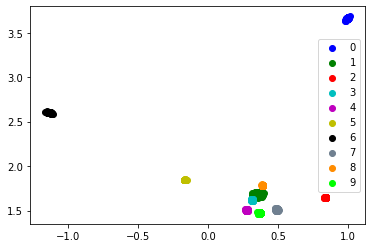

In [16]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'slategray', 'darkorange', 'lime']
for label, color in zip(cls.classes_, colors):
    class_embeddings = train_embeddings[y_train == label]
    plt.scatter(class_embeddings[:, 0], class_embeddings[:, 1], c=color, label=label)
plt.legend()
plt.show()

Apesar de mostrar um boa separação entre as classes, as representações das classes não são interessantes porque ficam praticamente agrupadas. Já as representaçõees de teste:

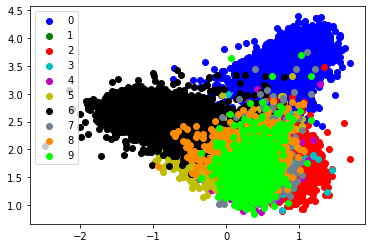

In [17]:
test_embeddings = cls.transform(X_test)

for label, color in zip(cls.classes_, colors):
    class_embeddings = test_embeddings[y_test == label]
    plt.scatter(class_embeddings[:, 0], class_embeddings[:, 1], c=color, label=label)

plt.legend()    
plt.show()

Essas amostras estão propensas a ficarem sobrepostas, e as classes se apresentam agrupadas. Nesse caso, adicionar uma quantidade maior de dimensões é essencial para conseguirmos separar essas amostras.